# Water Quality Prediction Project

## Project Documentation

**Problem Statement**  
Access to safe drinking water is essential for human health. Water sources may contain harmful contaminants such as heavy metals (lead, arsenic, mercury), chemicals (nitrates, chloramine), or biological hazards (bacteria, viruses). These pollutants can cause severe health issues if consumed above safe limits. The challenge is to build a machine learning model that can automatically predict whether water is safe (1) or not safe (0) based on its chemical and biological composition.

**Project Goal**  
• Develop an end-to-end ML pipeline to classify water samples as Safe or Not Safe.  
• Perform data ingestion, cleaning, transformation, feature engineering, EDA, model training, and evaluation.  
• Compare different ML algorithms (KNN, Random Forest, etc.) and select the best-performing model.  
• Provide a deployable solution (e.g., Streamlit/FastAPI app) to predict water safety.

**Data Collection**  
The dataset contains measurements of various water contaminants. Each feature has a known safety threshold.  
**Features (input variables):**  
• Aluminium – dangerous if > 2.8  
• Ammonia – dangerous if > 32.5  
• Arsenic – dangerous if > 0.01  
• Barium – dangerous if > 2  
• Cadmium – dangerous if > 0.005  
• Chloramine – dangerous if > 4  
• Chromium – dangerous if > 0.1  
• Copper – dangerous if > 1.3  
• Fluoride – dangerous if > 1.5  
• Bacteria – dangerous if > 0  
• Viruses – dangerous if > 0  
• Lead – dangerous if > 0.015  
• Nitrates – dangerous if > 10  
• Nitrites – dangerous if > 1  
• Mercury – dangerous if > 0.002  
• Perchlorate – dangerous if > 56  
• Radium – dangerous if > 5  
• Selenium – dangerous if > 0.5  
• Silver – dangerous if > 0.1  
• Uranium – dangerous if > 0.3  
**Target variable:**  
• is_safe (1 = safe, 0 = not safe)

**Data Cleaning**  
• Handle missing values:  
  o Numerical features → filled with mean.  
  o Categorical features (if any) → filled with mode.  
• Remove duplicates.  
• Ensure proper data types (float, int).

**Data Transformation**  
• Standardization/Normalization: Scale features to have similar ranges.  
• Encode categorical features (if applicable).  
• Outlier detection using domain thresholds.

**Feature Engineering**  
• Create binary features for “above threshold” vs “within safe limit”. Example:  
  • data["aluminium_high"] = (data["aluminium"] > 2.8).astype(int)  
• Interaction features: combine correlated chemicals (e.g., Nitrates + Nitrites).  
• Dimensionality reduction (if needed) using PCA.

**Exploratory Data Analysis (EDA)**  
• Distribution plots of each chemical.  
• Correlation heatmap.  
• Compare safe vs not safe water samples.  
• Boxplots to detect outliers.

**Model Training**  
• Split dataset: 70% train, 30% test.  
• Models to compare:  
  o KNN (K-Nearest Neighbors)  
  o Random Forest Classifier  
  o Logistic Regression  
  o SVM (Support Vector Machine)  
• Perform GridSearchCV for hyperparameter tuning.

**Model Evaluation**  
Metrics:  
• Accuracy  
• Precision, Recall, F1-score  
• Confusion Matrix  
• ROC-AUC curve  
Expected Outcome:  
• Best model selected automatically.  
• Accuracy > 90% (depending on dataset quality).

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, confusion_matrix
)
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


Step 1: Data Ingestion

In [4]:
# Load Dataset
file_path = "project_data.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"❌ File not found: {file_path}")

df = pd.read_csv(file_path)
print("✅ Data Loaded Successfully!")
print(f"Dataset Shape: {df.shape}")
df


✅ Data Loaded Successfully!
Dataset Shape: (7999, 21)


,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,NaN,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,0.05,7.78,0.00,1.95,0.040,0.10,0.03,0.03,1.37,0.00,...,0.197,14.29,1.00,0.005,3.57,2.13,0.09,0.06,0.03,1
7995,0.05,24.22,0.02,0.59,0.010,0.45,0.02,0.02,1.48,0.00,...,0.031,10.27,1.00,0.001,1.48,1.11,0.09,0.10,0.08,1
7996,0.09,6.85,0.00,0.61,0.030,0.05,0.05,0.02,0.91,0.00,...,0.182,15.92,1.00,0.000,1.35,4.84,0.00,0.04,0.05,1
7997,0.01,10,0.01,2.00,0.000,2.00,0.00,0.09,0.00,0.00,...,0.000,0.00,0.00,0.000,0.00,0.00,0.00,0.00,0.00,1


Step 2: Data Cleaning

In [5]:
# Convert columns to numeric
for col in df.columns:
    if col != "is_safe":
        df[col] = pd.to_numeric(df[col], errors="coerce")

if "is_safe" in df.columns:
    df["is_safe"] = pd.to_numeric(df["is_safe"], errors="coerce")
    df = df[df["is_safe"].isin([0, 1])]   # keep only binary classes

# Handle missing values
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

print("✅ Data Cleaned Successfully!")
print(f"Cleaned Dataset Shape: {df.shape}")
df


✅ Data Cleaned Successfully!
Cleaned Dataset Shape: (7996, 21)


C:\Users\kumar\AppData\Local\Temp\ipykernel_29384\2154858161.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(df[col].mean(), inplace=True)


,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.050000,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1.0
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.900000,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1.0
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.990000,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0.0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.080000,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1.0
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.772025,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,0.05,7.78,0.00,1.95,0.040,0.10,0.03,0.03,1.370000,0.00,...,0.197,14.29,1.00,0.005,3.57,2.13,0.09,0.06,0.03,1.0
7995,0.05,24.22,0.02,0.59,0.010,0.45,0.02,0.02,1.480000,0.00,...,0.031,10.27,1.00,0.001,1.48,1.11,0.09,0.10,0.08,1.0
7996,0.09,6.85,0.00,0.61,0.030,0.05,0.05,0.02,0.910000,0.00,...,0.182,15.92,1.00,0.000,1.35,4.84,0.00,0.04,0.05,1.0
7997,0.01,10.00,0.01,2.00,0.000,2.00,0.00,0.09,0.000000,0.00,...,0.000,0.00,0.00,0.000,0.00,0.00,0.00,0.00,0.00,1.0


Step 3: Exploratory Data Analysis (EDA)

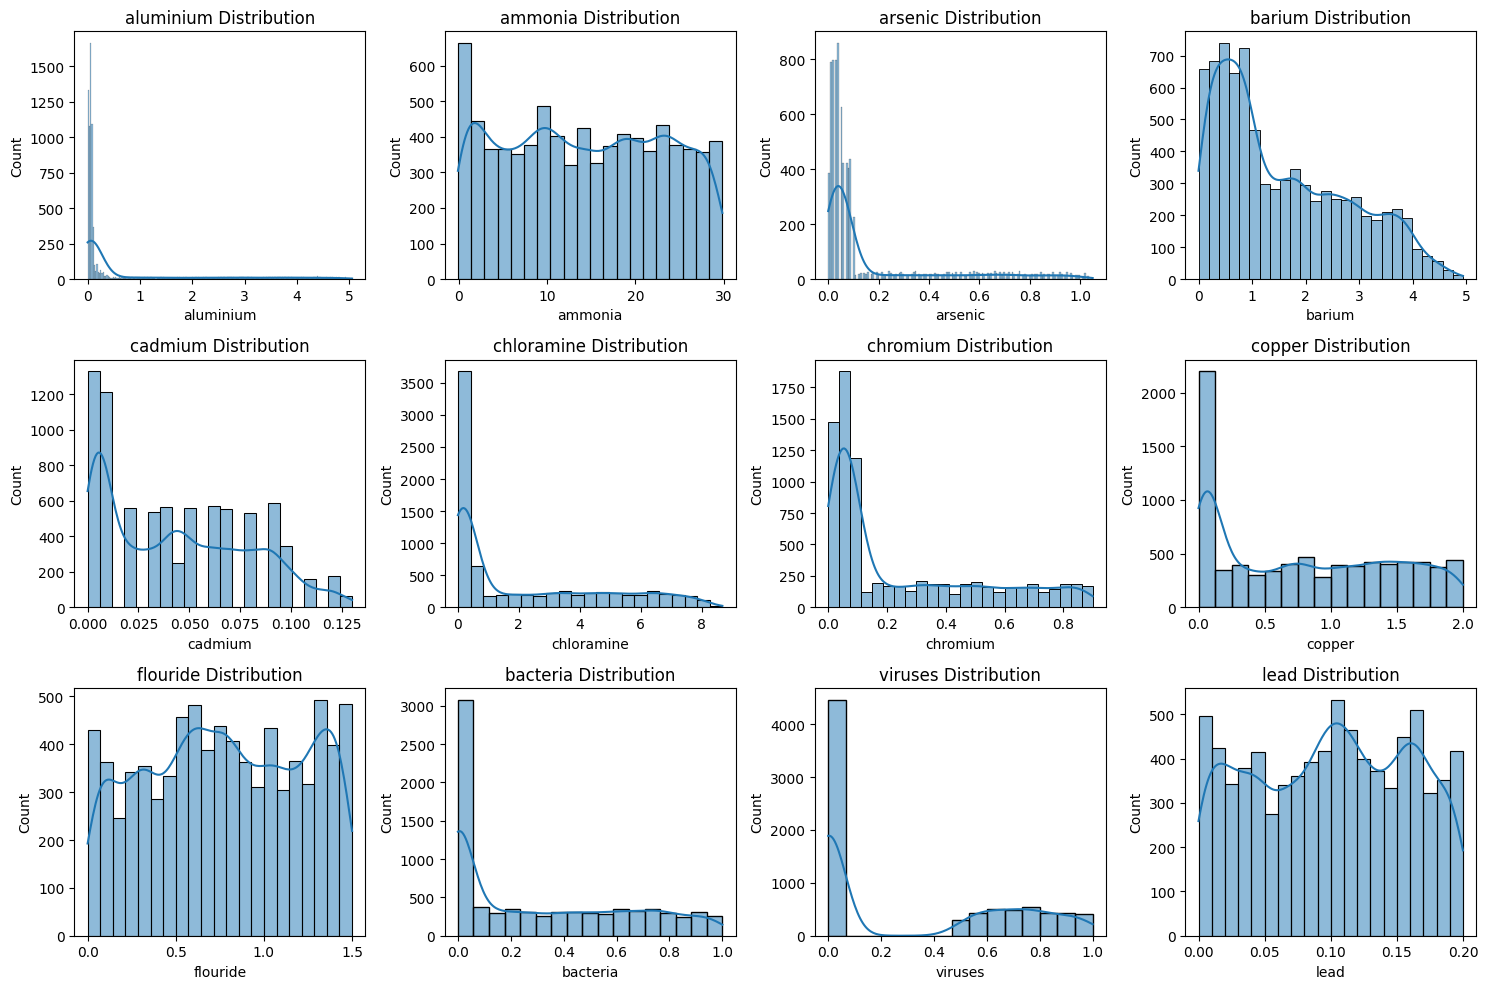

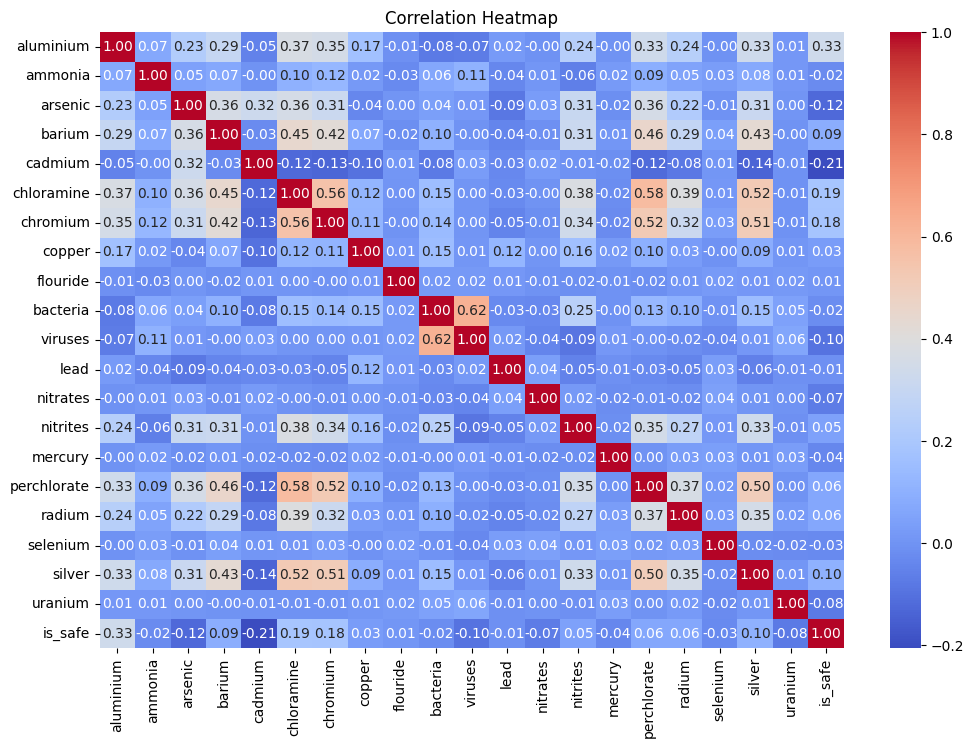

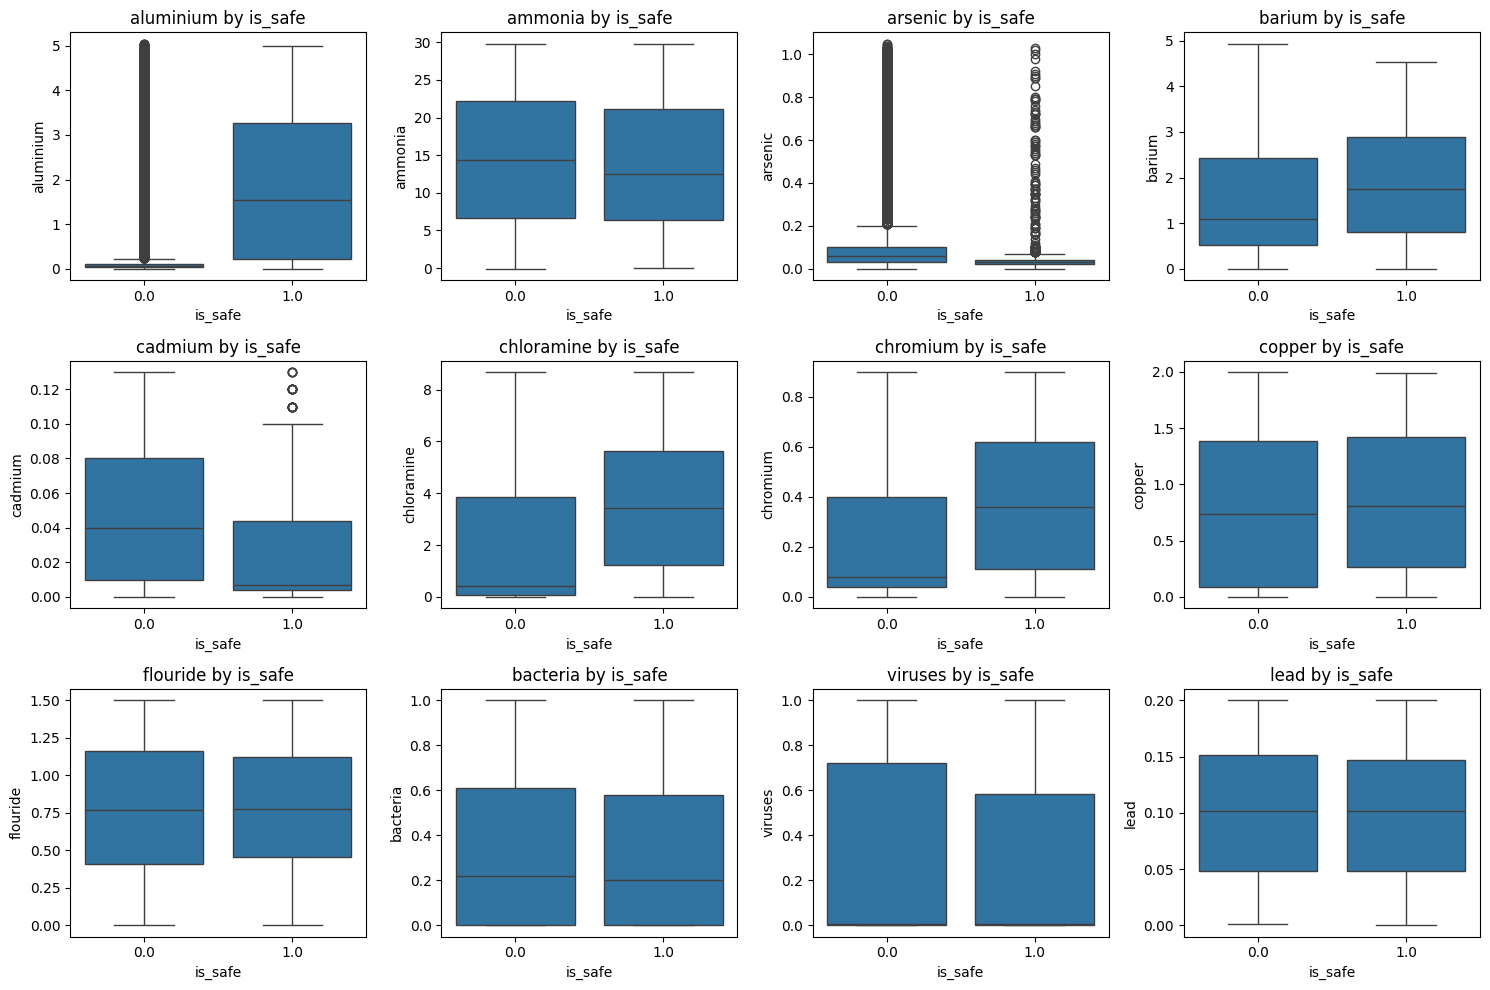

is_safe
0.0    0.885943
1.0    0.114057
Name: proportion, dtype: float64

In [6]:
features = df.drop(columns=["is_safe"]).columns

# Distribution Plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features[:12], 1):  # show first 12 features
    plt.subplot(3, 4, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} Distribution")
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Boxplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features[:12], 1):  # first 12 features
    plt.subplot(3, 4, i)
    sns.boxplot(x="is_safe", y=feature, data=df)
    plt.title(f"{feature} by is_safe")
plt.tight_layout()
plt.show()

# Class Distribution
df["is_safe"].value_counts(normalize=True)


Step 4: Feature Engineering

In [8]:
thresholds = {
    "aluminium": 2.8, "ammonia": 32.5, "arsenic": 0.01, "barium": 2,
    "cadmium": 0.005, "chloramine": 4, "chromium": 0.1, "copper": 1.3,
    "fluoride": 1.5, "bacteria": 0, "viruses": 0, "lead": 0.015,
    "nitrates": 10, "nitrites": 1, "mercury": 0.002, "perchlorate": 56,
    "radium": 5, "selenium": 0.5, "silver": 0.1, "uranium": 0.3
}

# Add danger flags
for col, th in thresholds.items():
    if col in df.columns:
        df[f"{col}_high"] = (df[col] > th).astype(int)

# Count how many exceed safe levels
danger_flags = [f"{col}_high" for col in thresholds.keys() if f"{col}_high" in df.columns]
df["danger_count"] = df[danger_flags].sum(axis=1)

# Ratios
if "nitrates" in df.columns and "nitrites" in df.columns:
    df["nitrate_nitrite_ratio"] = np.where(df["nitrites"] > 0, df["nitrates"] / df["nitrites"], 0)

if "copper" in df.columns and "lead" in df.columns:
    df["copper_lead_ratio"] = np.where(df["lead"] > 0, df["copper"] / df["lead"], 0)

# Interaction
if "bacteria" in df.columns and "viruses" in df.columns:
    df["bacteria_viruses"] = df["bacteria"] * df["viruses"]

print("✅ Feature Engineering Complete!")
df

✅ Feature Engineering Complete!


,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,mercury_high,perchlorate_high,radium_high,selenium_high,silver_high,uranium_high,danger_count,nitrate_nitrite_ratio,copper_lead_ratio,bacteria_viruses
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.050000,0.20,...,1,0,1,0,1,0,11,14.230088,3.148148,0.00000
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.900000,0.65,...,1,0,0,0,1,0,9,1.041451,6.600000,0.42250
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.990000,0.05,...,1,0,1,0,1,0,12,12.756757,0.256410,0.00015
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.080000,0.71,...,1,0,0,0,1,0,10,1.093023,103.750000,0.50410
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.772025,0.13,...,1,0,0,0,0,0,8,6.072072,4.871795,0.00013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,0.05,7.78,0.00,1.95,0.040,0.10,0.03,0.03,1.370000,0.00,...,1,0,0,0,0,0,4,14.290000,0.152284,0.00000
7995,0.05,24.22,0.02,0.59,0.010,0.45,0.02,0.02,1.480000,0.00,...,0,0,0,0,0,0,4,10.270000,0.645161,0.00000
7996,0.09,6.85,0.00,0.61,0.030,0.05,0.05,0.02,0.910000,0.00,...,0,0,0,0,0,0,3,15.920000,0.109890,0.00000
7997,0.01,10.00,0.01,2.00,0.000,2.00,0.00,0.09,0.000000,0.00,...,0,0,0,0,0,0,0,0.000000,0.000000,0.00000


Step 5: Data Splitting & Feature Scaling

In [9]:
X = df.drop(columns=["is_safe"])
y = df["is_safe"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Resampling with SMOTEENN
smt = SMOTEENN(smote=SMOTE(k_neighbors=1, random_state=42), random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

print("✅ Data Splitting & Resampling Done!")
print("Original Class Distribution:", dict(y_train.value_counts()))
print("Resampled Class Distribution:", dict(pd.Series(y_train_res).value_counts()))


✅ Data Splitting & Resampling Done!
Original Class Distribution: {0.0: 4959, 1.0: 638}
Resampled Class Distribution: {1.0: 4872, 0.0: 3862}


Step 6: Model Training & Evaluation

In [10]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    cm = confusion_matrix(true, predicted)
    return acc, f1, precision, recall, roc_auc, cm

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Support Vector Classifier": SVC(probability=True, random_state=42),
}

results = []

for model_name, model in models.items():
    print(f"\n🚀 Training {model_name}...")
    model.fit(X_train_res, y_train_res)
    
    y_test_pred = model.predict(X_test)
    test_acc, test_f1, test_prec, test_recall, test_auc, test_cm = evaluate_clf(y_test, y_test_pred)
    
    print(f"📊 {model_name} Performance:")
    print(f"- Accuracy: {test_acc:.4f}")
    print(f"- F1 Score: {test_f1:.4f}")
    print(f"- Precision: {test_prec:.4f}")
    print(f"- Recall: {test_recall:.4f}")
    print(f"- ROC-AUC: {test_auc:.4f}")
    print(f"- Confusion Matrix:\n{test_cm}")
    print("=" * 40)
    
    results.append([model_name, test_acc, test_auc])

results_df = pd.DataFrame(results, columns=["Model Name", "Test Accuracy", "Test ROC-AUC"]).sort_values(by="Test Accuracy", ascending=False)
results_df



🚀 Training Random Forest...
📊 Random Forest Performance:
- Accuracy: 0.9283
- F1 Score: 0.7378
- Precision: 0.6335
- Recall: 0.8832
- ROC-AUC: 0.9087
- Confusion Matrix:
[[1985  140]
 [  32  242]]

🚀 Training Decision Tree...
📊 Decision Tree Performance:
- Accuracy: 0.9254
- F1 Score: 0.7242
- Precision: 0.6267
- Recall: 0.8577
- ROC-AUC: 0.8959
- Confusion Matrix:
[[1985  140]
 [  39  235]]

🚀 Training Gradient Boosting...
📊 Gradient Boosting Performance:
- Accuracy: 0.9033
- F1 Score: 0.6848
- Precision: 0.5455
- Recall: 0.9197
- ROC-AUC: 0.9104
- Confusion Matrix:
[[1915  210]
 [  22  252]]

🚀 Training Logistic Regression...
📊 Logistic Regression Performance:
- Accuracy: 0.7941
- F1 Score: 0.4756
- Precision: 0.3353
- Recall: 0.8175
- ROC-AUC: 0.8043
- Confusion Matrix:
[[1681  444]
 [  50  224]]

🚀 Training K-Neighbors Classifier...
📊 K-Neighbors Classifier Performance:
- Accuracy: 0.7687
- F1 Score: 0.4596
- Precision: 0.3134
- Recall: 0.8613
- ROC-AUC: 0.8090
- Confusion Matrix:

c:\Users\kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:13:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 XGBClassifier Performance:
- Accuracy: 0.9333
- F1 Score: 0.7583
- Precision: 0.6469
- Recall: 0.9161
- ROC-AUC: 0.9258
- Confusion Matrix:
[[1988  137]
 [  23  251]]

🚀 Training Support Vector Classifier...
📊 Support Vector Classifier Performance:
- Accuracy: 0.8812
- F1 Score: 0.6275
- Precision: 0.4888
- Recall: 0.8759
- ROC-AUC: 0.8789
- Confusion Matrix:
[[1874  251]
 [  34  240]]


,Model Name,Test Accuracy,Test ROC-AUC
5,XGBClassifier,0.933306,0.925794
0,Random Forest,0.928303,0.908665
1,Decision Tree,0.925386,0.895891
2,Gradient Boosting,0.903293,0.910442
6,Support Vector Classifier,0.881201,0.878897
3,Logistic Regression,0.794081,0.804289
4,K-Neighbors Classifier,0.768654,0.809010


Step 7: Save Results

In [11]:
os.makedirs("models", exist_ok=True)
results_df.to_csv("models/model_results.csv", index=False)
print("✅ Model results saved to models/model_results.csv")


✅ Model results saved to models/model_results.csv
